### **Deep Learning Group Project 23-24**

##### **Group 5**

**Elements**:
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- Samuel Santos | 20220609 | 20220609@novaims.unl.pt
- Afonso Gorjão | 20230575 | 20230575@novaims.unl.pt
- Pedro Carvalho | 20230554 | 20230554@novaims.unl.pt
- Francisco Campos | 20230565 | 20250565@novaims.unl.pt


**In this notebook:**
1. Data Exploration.
2. Duplicate Removal.
3. Data Split into Train, Validation and Test sets.


**Index**
1. [Library imports](#library_imports)
2. [Data (not resized) import](#data_import)
3. [Fitzpatrick scale analysis](#fitz_scale)
4. [Image shape and size analysis](#image_analysis)
5. [Checking for duplicates](#check_duplicates)
6. [Label analysis](#label_analysis)
7. [Train-val-test split](#data_split)
8. [Storing data in TF-efficient way](#storing_data)
9. [Data (resized) import](#resize_import)
10. [Common sample visualizations](#sample_vis)


#### **Library imports**<a id='library_imports'></a>

In [1]:
import os
import shutil
import pathlib
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import imagehash

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split

from utils.visuals import SampleVisuals

#### **Data (not resized) import**<a id='data_import'></a>

In [3]:
images = []
for dirpath, dirname, filename in os.walk(os.path.join('data', 'all-images')):
    images += [os.path.join(dirpath, file) for file in filename]

In [4]:
rawdata = pd.read_csv('data/fitzpatrick17k.csv')
rawdata.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


#### **Fitzpatrick scale analysis**<a id='fitz_scale'></a>

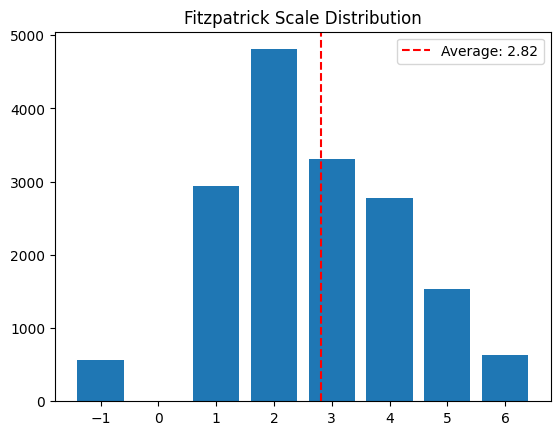

In [5]:
# *********************************
# Analysing image shapes and sizes
# *********************************

# According to the fitzpatrik scale:
# 1 & 2: light skins
# 3 & 4: medium skins
# 5 & 6: dark skins
# -1: unknown

fitz_scale = rawdata['fitzpatrick_scale'].value_counts().sort_index()
scale_mean = np.mean([i for i in rawdata['fitzpatrick_scale'] if i != -1])
plt.bar(x = fitz_scale.index, height = fitz_scale.values)
plt.axvline(x=scale_mean, color='r', linestyle='--', label=f'Average: {round(scale_mean, 2)}')
plt.legend()
plt.title('Fitzpatrick Scale Distribution')
plt.show()

#### **Image shape and size analysis**<a id='image_analysis'></a>

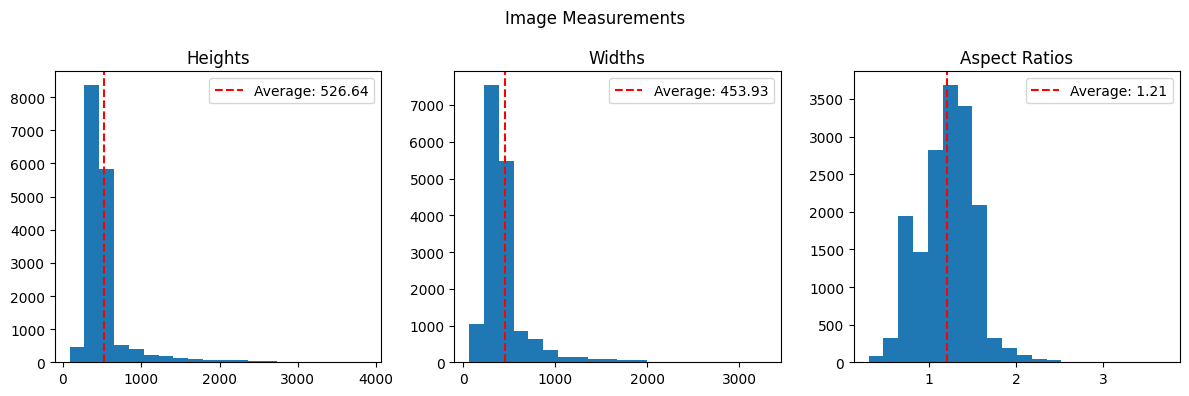

In [5]:
# *********************************
# Analysing image shapes and sizes
# *********************************

heights, widths = [], []
for path in images:
    image = Image.open(path)
    height, width = image.size
    heights.append(height)
    widths.append(width)

heights = np.array(heights)
widths = np.array(widths)
aspectratios = heights / widths

mean_height = np.mean(heights)
mean_width = np.mean(widths)
mean_aspectratio = np.mean(aspectratios)

# plotting

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Image Measurements')

ax1.hist(heights, bins=20) 
ax1.set_title("Heights")
ax1.axvline(x=mean_height, color='r', linestyle='--', label=f'Average: {round(mean_height, 2)}')
ax1.legend()

ax2.hist(widths, bins=20) 
ax2.set_title("Widths")
ax2.axvline(x=mean_width, color='r', linestyle='--', label=f'Average: {round(mean_width, 2)}')
ax2.legend()

ax3.hist(aspectratios, bins=20) 
ax3.set_title("Aspect Ratios")
ax3.axvline(x=mean_aspectratio, color='r', linestyle='--', label=f'Average: {round(mean_aspectratio, 2)}')
ax3.legend()

plt.tight_layout()
plt.show()

# on average, images are originally rectangular

#### **Checking for duplicates**<a id='check_duplicates'></a>

In [6]:
# https://github.com/JohannesBuchner/imagehash
# !pip install imagehash

img_hashes = {}
duplicate_images = []
for img in images:
    # ideally the images should be of the same size
    # and grey scale (two images should be the same
    # even if they share the same color)
    hash_ = imagehash.average_hash(Image.open(img)
                                   .resize((128, 128))
                                   .convert('L'),
                                   hash_size=16)  # low hash size => false positives vs. high hash size => false negatives
    if hash_ in img_hashes:
        # debugging
        # print(f'{img} duplicate of {img_hashes[hash_]}')
        duplicate_images.append((img, img_hashes[hash_]))
    else:
        img_hashes[hash_] = img

print(f"No. of pairs of duplicates: {len(duplicate_images)}")

No. of pairs of duplicates: 15


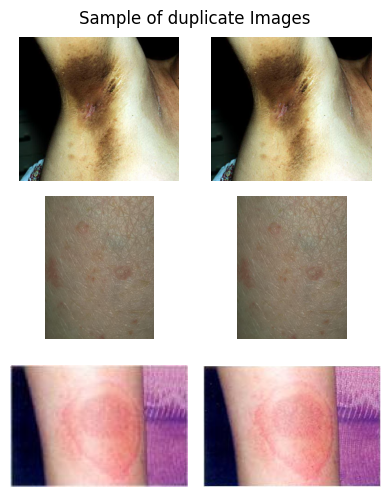

In [25]:
def show_duplicates(*image_paths):
    images = []
    # for img1_path, img2_path in image_paths:
    #     img1 = Image.open(img1_path); img2 = Image.open(img2_path)
    #     images.append((img1, img2))
    for path in image_paths:
        img = Image.open(path)
        images.append(img)
   
    plt.figure(figsize=(4, 10))
    plt.suptitle('Sample of duplicate Images')
    nrows, ncols = len(images), 2
    for i in range(nrows):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()


show_duplicates(*duplicate_images[0], *duplicate_images[1], *duplicate_images[2])

# although there are definitely duplicate images
# not all are exact duplicates, e.g. image 5

In [6]:
# making sure duplicates are actual dupes

for i in duplicate_images[0]:
    hash_ = os.path.split(i)[-1].split('.')[0]
    print(rawdata.loc[rawdata['md5hash'] == hash_, 'url'].values[0])

https://www.dermaamin.com/site/images/clinical-pic/a/acanthosis_nigricans/acanthosis_nigricans38.jpg
https://www.dermaamin.com/site/images/clinical-pic/a/acanthosis_nigricans/acanthosis_nigricans20.jpg


In [14]:
# removing the duplicate images

# the idea here is to, for each pair remove the first image and keep
# the second one, if they belong to the same class, otherwise remove
# both images. Why? If it were random we would need to set a seed
# because otherwise running the code twice would lead to different
# datasets. Also, for two different classes, as we lack the needed
# domain knowledge we would also like to avoid bias by randomly
# oversourcing one class and undersourcing the other one.

diff_class_counter = 0
for pair in duplicate_images:
    classes = {pathlib.Path(path).parts[2] for path in pair}
    if len(classes) > 1:
        diff_class_counter += 1

print(f"No. of pairs of duplicate images that share the same class: {diff_class_counter}/{len(duplicate_images)}")

img_to_remove = []
for pair in duplicate_images:
    # if they belong to same class remove one of the two
    if pathlib.Path(pair[0]).parts[2] == pathlib.Path(pair[1]).parts[2]:
        img_to_remove.append(pair[0])
    # if they belong to diff. classes remove both
    else:
        img_to_remove.append(pair[0])
        img_to_remove.append(pair[1])

images = [img for img in images if img not in img_to_remove]

print(f"New dataset observation count: {len(images)}")

# No. of total observations:
# 16577 (original number of rows in fitzpatrick.csv)
# - 41 (missing URLs)
# - 10 (error URLs)
# - 14 (duplicates of same class)
# - 2 (pair of duplicates of diff. classes)
# = 16510

No. of pairs of duplicate images that share the same class: 1/15
New dataset observation count: 16510


#### **Label analysis**<a id='label_analysis'></a>

16526
114
[('psoriasis', 653), ('squamous cell carcinoma', 581), ('lichen planus', 491), ('basal cell carcinoma', 468), ('allergic contact dermatitis', 430)]
[('port wine stain', 59), ('erythema elevatum diutinum', 55), ('pilomatricoma', 53), ('pustular psoriasis', 53), ('xanthomas', 53)]
144.96491228070175
113.81440184395633


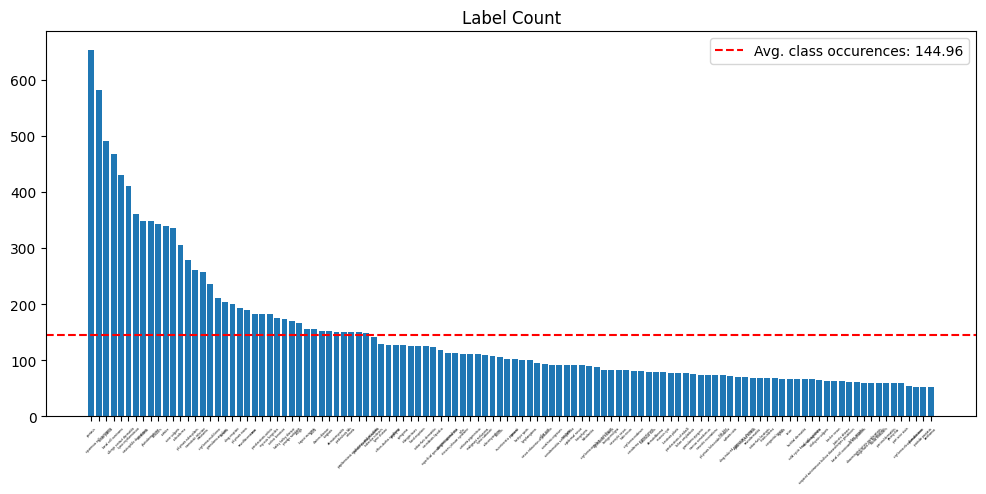

In [38]:
label_counter = Counter([pathlib.Path(path).parts[2] for path in images])
label_counter = Counter(OrderedDict(label_counter.most_common()))  # sorting (for the plot)

print(sum(label_counter.values()))
print(len(label_counter.keys()))
print(label_counter.most_common()[:5])  # most common classes
print(label_counter.most_common()[-5:])  # least common classes

avg_class_occurences = np.mean(list(label_counter.values()))
print(np.mean(list(label_counter.values())))  # avg. class occurrences
print(np.std(list(label_counter.values())))  # std class occurences

plt.figure(figsize=(12, 5))
plt.bar(x=label_counter.keys(), height=label_counter.values())
plt.title('Label Count')
plt.xticks(rotation=45)
plt.tick_params(axis='x',labelsize=2)
plt.axhline(y=avg_class_occurences, label=f'Avg. class occurences: {avg_class_occurences:.2f}', color='r', linestyle='--')
plt.legend()
plt.show()

# great class imbalance => stratify
# we can also see we still have 114 categories having at least 53 images and a maximum of 653 images

#### **Train-val-test split**<a id='data_split'></a>

In [16]:
# *********************************
# Train-val-test split
# *********************************

# why not k-fold cross validation: https://datascience.stackexchange.com/questions/47797/using-cross-validation-technique-for-a-cnn-mod

X = images.copy()
y = [pathlib.Path(path).parts[2] for path in images].copy()

def two_step_proportions(train_p, val_p, test_p):
    """
    Since we need to split the data in two steps
    this function returns the proportions of the
    'test_size' arg. needed to get the true prop.
    """ 
    return (test_p, 1-(train_p/(1-test_p)))

test_size_1, test_size_2 = two_step_proportions(.7, .15, .15)

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=test_size_1,
                                                            shuffle=True,
                                                            stratify=y,
                                                            random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=test_size_2,
                                                  shuffle=True,
                                                  stratify=y_train_val,
                                                  random_state=42)

get_prop = lambda d: round(len(d) / len(X) * 100, 2)
print('Dataset shapes:')
print(f'\tTrain: {len(X_train)} ({get_prop(X_train)}%)')
print(f'\tVal: {len(X_val)} ({get_prop(X_val)}%)')
print(f'\tTest: {len(X_test)} ({get_prop(X_test)}%)')
print(f"\nTotal observations: {len(X)}")

Dataset shapes:
	Train: 11556 (69.99%)
	Val: 2477 (15.0%)
	Test: 2477 (15.0%)

Total observations: 16510


#### **Storing data in TF-efficient way**<a id='storing_data'></a>

In [17]:
# ***********************************
# Storing data in TF-efficient way
# ***********************************

datasets = [(X_train, y_train, 'train'),
            (X_val, y_val, 'val'),
            (X_test, y_test, 'test')]

for data, labels, name in datasets:
    print(f'Copying images into {name}...')
    os.makedirs(os.path.join('data', name))
    dirs = {}  # i.e. key: class name vs. value: list of image paths that belong to that class
    for path, label in zip(data, labels):
        if label not in dirs.keys():
            dirs[label] = [path]
        else:
            dirs[label] += [path]
    
    for label, path_list in dirs.items():
        os.makedirs(os.path.join('data', name, label))
        for src in path_list:
            filename = os.path.split(src)[-1]  # name of image e.g. a3ft35.jpg
            dst = os.path.join('data', name, label, filename)
            shutil.copy(src, dst)

Copying images into train...
Copying images into val...
Copying images into test...


#### **Importing (resized) data**<a id='resize_import'></a>

In [6]:
# *********************************
# Importing data (resized)
# *********************************

train_path = os.path.join('data', 'train')
val_path = os.path.join('data', 'val')
test_path = os.path.join('data', 'test')

# with the exception of the directory arg all
# other args will be the same for each set
import_kwargs = {
    'labels': 'inferred',
    'label_mode': 'categorical',
    'color_mode': 'rgb',
    'batch_size': 32,
    'image_size': (128, 128),
    'seed': None,
    'interpolation': 'bilinear',
    'crop_to_aspect_ratio': True
}

# this function returns a tf.data.Dataset object
train_data = image_dataset_from_directory(
    train_path,
    shuffle=True,
    **import_kwargs
)

val_data = image_dataset_from_directory(
    val_path,
    shuffle=True,
    **import_kwargs
)

test_data = image_dataset_from_directory(
    test_path,
    shuffle=True,
    **import_kwargs
)

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
